# First Laboratory of Machine Learning per il Calcolo Sceintifico
In this notebook, we want to create the network from the paper "Error bounds for approximations with deep ReLU networks" by D. Yarotsky (Neural Netowrks, 2017, https://doi.org/10.1016/j.neunet.2017.07.002).



## Step zero: libraries

Install  Python (https://www.python.org/)

And the following libraries:

-PyTorch (https://pytorch.org/)

-Numpy (https://numpy.org/)

-Matplotlib (https://matplotlib.org/)


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device) # default tensor device
print("I'm using: ", device)


I'm using:  cpu


## First step: Define $\Phi^\wedge$ using torch Tensor 
Define the weights and the bias of the NN $\Phi^\wedge$ with ReLU activation, seen during the lecutres that emulates $F_1$ and plot in on [0,1] 
$$
F_1 : x\mapsto 
\begin{cases}
2x &x\in (0, 1/2]\\
2-2x &x \in (1/2, 1)\\
0 &\text{elsewhere.}
\end{cases}
$$
We want to define the hidden weight $W_1 \in \mathbb{R}^{3\times 1}$ and bias $b\in \mathbb{R}^{1\times 3}$ and the output weight $W_2\in \mathbb{R}^{1\times 3}$. The NN then will be the map
$$
x\mapsto \left[\mathrm{ReLU}(xW_1^\top + b)\right] W_2^\top
$$
where $x \in \mathbb{R}^{N\times 1}$ can be a vector of $N$ points in $[0,1]$. Note that we choose the formulation above to follow the format implemented in `torch.nn.Linear`, see https://pytorch.org/docs/stable/generated/torch.nn.Linear.html. 

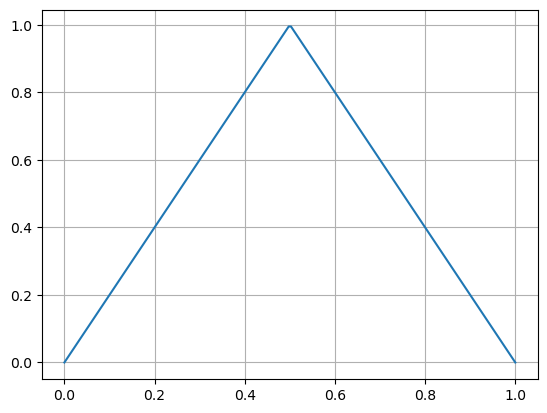

In [2]:
input_weight_mat = torch.tensor([[2.], [2.], [2.]]) 
input_bias_vec = torch.tensor([0., -1., -2.])
output_weight_mat = torch.tensor([1., -2., 1.]).unsqueeze(0)

with torch.inference_mode():
    x = torch.linspace(0, 1, 200).unsqueeze(-1)
    y = torch.relu(x@input_weight_mat.t() + input_bias_vec)@output_weight_mat.t()

    x_np = x.cpu()
    
    plt.plot(x_np, y.squeeze().cpu(), label='f')
    plt.grid()
    plt.show()

We now do the same thing using `torch.nn.Linear`

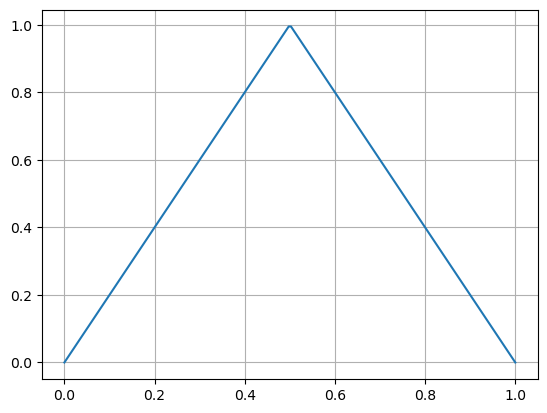

In [3]:
hidden_layer = torch.nn.Linear(1, 3)
output_layer = torch.nn.Linear(3, 1, bias=False)

hidden_layer.weight = torch.nn.Parameter(input_weight_mat)
hidden_layer.bias = torch.nn.Parameter(input_bias_vec)
output_layer.weight = torch.nn.Parameter(output_weight_mat)

with torch.inference_mode():
    x = torch.linspace(0, 1, 200).unsqueeze(-1)
    y = output_layer(torch.relu(hidden_layer(x)))

    x_np = x.cpu()
    
    plt.plot(x_np, y.squeeze().cpu(), label='f')
    plt.grid()
    plt.show()

## Second step: define a general Feed-Forward Neural Network

Complete the following Python class of a FNN (This will be used in future laboratories!)

In [4]:
class DeepNet(torch.nn.Module):
    def __init__(self, activation, n_input, n_hidden=None, n_output=None):
        """
        construct a NN with
        activation: activation function
        n_input: input dimension
        n_hidden: list of hidden layer widths
        n_output: output dim
        """
        super(DeepNet, self).__init__()  # Constructor of the super class torch.nn.Module
        torch.manual_seed(0) # set the seed for reproducibility
        self.dim_in = n_input
        self.activation = activation
        self.hidden = torch.nn.ModuleList()
        if n_hidden is not None:
            self.L = len(n_hidden)
            self.widths = n_hidden
            self.hidden.append(torch.nn.Linear(n_input, n_hidden[0]))
            torch.nn.init.xavier_normal_(self.hidden[0].weight)
            torch.nn.init.normal_(self.hidden[0].bias)
            for i in range(1, self.L):
                self.hidden.append(torch.nn.Linear(n_hidden[i-1], n_hidden[i]))
                torch.nn.init.xavier_normal_(self.hidden[i].weight)
                torch.nn.init.normal_(self.hidden[i].bias)
        else:
            self.L = 0

        if n_output is not None:
            self.dim_out = n_output
            self.output = torch.nn.Linear(n_hidden[-1], n_output, bias=False)
            torch.nn.init.xavier_normal_(self.output.weight)
        else:
            self.output = None

    def forward(self, x):
        """
        Given input vector x produces the output of the NN
        """
        if x.dim() == 1:
            x = x.unsqueeze(-1) # add a dimension at the end
        for i in range(self.L):
            x = self.hidden[i](x)
            x = self.activation(x)
            
        if self.output is not None:
            x = self.output(x)
        return x

    #Functions needed for Exercise 2
    def set_weight(self, layer, weight_mat, requires_grad=True):
        assert self.L > layer
        assert weight_mat.shape == self.hidden[layer].weight.shape
        self.hidden[layer].weight = torch.nn.Parameter(weight_mat, requires_grad=requires_grad)

    def set_bias(self, layer, bias_mat):
        assert self.L > layer
        assert bias_mat.flatten().shape == self.hidden[layer].bias.shape
        self.hidden[layer].bias = torch.nn.Parameter(bias_mat)

    def set_output_weight(self, weight_mat, requires_grad=True):
        assert self.output is not None
        assert weight_mat.shape == self.output.weight.shape
        self.output.weight = torch.nn.Parameter(weight_mat, requires_grad=requires_grad)

    def set_output_bias(self, bias_mat):
        assert self.output is not None
        assert bias_mat.flatten().shape == self.output.bias.shape
        self.output.bias = torch.nn.Parameter(bias_mat)

### Create a FNN with 1 layer 3 neurons and ReLU activation function

In [5]:
input = 1
output = 1
hidden_layer = [3]
activation_function = torch.relu

FNN = DeepNet(activation_function,input,hidden_layer,output)
FNN

DeepNet(
  (hidden): ModuleList(
    (0): Linear(in_features=1, out_features=3, bias=True)
  )
  (output): Linear(in_features=3, out_features=1, bias=False)
)

### Redefine $\Phi^\wedge$ using the FNN defined before  

In [6]:
Phiwedge = FNN 

Phiwedge.set_weight(0, input_weight_mat)
Phiwedge.set_bias(0, input_bias_vec) 

Phiwedge.set_output_weight(output_weight_mat)

Plot the output of the NN in [0,1].

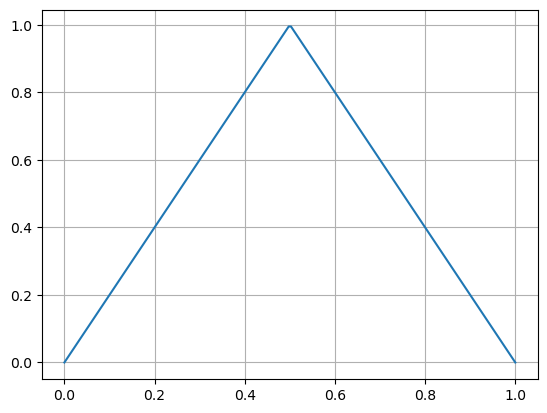

In [7]:
with torch.inference_mode():
    x = torch.linspace(0, 1, 200)
    y = Phiwedge(x)

    x_np = x.cpu()
    
    plt.plot(x_np, y.cpu(), label='f')
    plt.grid()
    plt.show()

## Third step: Concatenation of two Networks
Complete the following code which implements the non-sparse concatenation

In [8]:
def concatenate(nn1, nn2):
    assert nn1.dim_out == nn2.dim_in
    assert nn1.activation == nn2.activation
    new_L = nn1.L + nn2.L 
    new_widths = nn1.widths + nn2.widths
    out_net = DeepNet(nn1.activation, nn1.dim_in, new_widths, nn2.dim_out)

    for i in range(nn1.L):
        out_net.set_weight(i, nn1.hidden[i].weight)
        out_net.set_bias(i, nn1.hidden[i].bias)
    new_weight = nn2.hidden[0].weight@nn1.output.weight
    out_net.set_weight(nn1.L, new_weight)
    out_net.set_bias(nn1.L, nn2.hidden[0].bias)
    for i in range(1, nn2.L):
        out_net.set_weight(nn1.L+i, nn2.hidden[i].weight)
        out_net.set_bias(nn1.L+i, nn2.hidden[i].bias)
    out_net.set_output_weight(nn2.output.weight)

    return out_net

Concatenate the NN $\Phi^\wedge$ defined in the second step 4 time ($F_4 = F_1\circ F_1 \circ F_1 \circ F_1$) 

DeepNet(
  (hidden): ModuleList(
    (0): Linear(in_features=1, out_features=3, bias=True)
    (1-3): 3 x Linear(in_features=3, out_features=3, bias=True)
  )
  (output): Linear(in_features=3, out_features=1, bias=False)
)


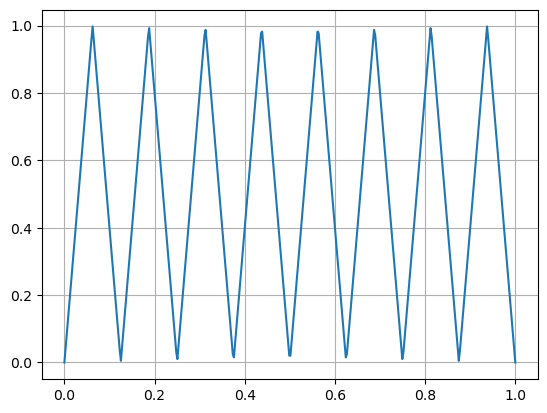

In [9]:
F4 = concatenate(concatenate(concatenate(Phiwedge, Phiwedge), Phiwedge), Phiwedge)

print(F4)
with torch.inference_mode():
    x = torch.linspace(0, 1, 400)
    y = F4(x)

    x_np = x.cpu().numpy()
    
    plt.plot(x_np, y.cpu().numpy(), label='f')
    plt.grid()
    plt.show()

## Fourth step: Define the Yarotsky Network 

We now want to construct the network from Yarotsky's paper. Defining by $F_n$ the $n$-fold composition of $\Phi^\wedge$, we use the fact that
$$
x - \sum_{k=1}^N \frac{F_k(x)}{4^k} \to x^2, \qquad \text{as }N\to\infty,
$$ 
for all $x\in[0,1]$. The network therefore uses a non-standard architecture, as shown in this picture:

<center>
    <img src="./Yarotsky-arch.png" alt="Architecture">
</center>

In [10]:
class YarotskyNet(DeepNet):
    def __init__(self, net, out_weights):
        """
        Initialize by copying a net given as input, and a vector of
        weights that are the weights of the skip connections
        """
        super(YarotskyNet, self).__init__(net.activation, net.dim_in, net.widths, net.dim_out)
        self.out_weights = out_weights
        for i in range(net.L):
            self.hidden[i] = net.hidden[i]
        self.output = net.output
        assert len(out_weights) == len(net.widths) + 1
 
    def forward(self, x):
        if x.dim() == 1:
            x = x[:, None]
        y = self.out_weights[0]*x
        for i in range(self.L):
            x = self.hidden[i](x)
            x = self.activation(x)
            y = y + self.out_weights[i+1]*self.output(x)
        return y

Define a Yarotsky network, with depth = 3

In [11]:
with torch.inference_mode():
    depth = 3

    out_weights = [-4**(-k) for k in range(depth)]
    out_weights[0] = 1

    basenet = Phiwedge
    for j in range(depth-2):
        basenet = concatenate(basenet, Phiwedge)
        

    squarenet = YarotskyNet(basenet, out_weights)


Plot the output of the Yarotsky network over [0,1] and compare it with respect to $x^2$. Then evaluate the $L^2$ error

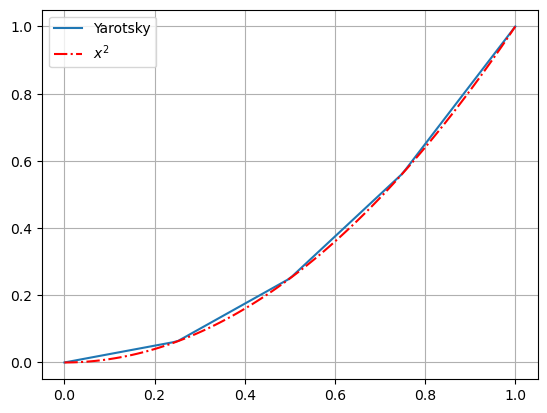

L2 error: 1.135369e-02


In [12]:
with torch.inference_mode():
    depth = 3

    out_weights = [-4**(-k) for k in range(depth)]
    out_weights[0] = 1

    basenet = Phiwedge
    for j in range(depth-2):
        basenet = concatenate(basenet, Phiwedge)
        

    squarenet = YarotskyNet(basenet, out_weights)


    x = torch.linspace(0, 1, 100)
    y = squarenet(x)

    x_np = x.cpu().numpy()


    plt.plot(x_np, y.cpu().numpy(), label='Yarotsky')
    plt.plot(x_np, x_np**2, 'r-.',label = '$x^2$')
    plt.grid()
    plt.legend()
    plt.show()

    print(f'L2 error: {np.linalg.norm(y.cpu().numpy().flatten()-x_np**2)/10:4e}')

Evalute the $L^2$ error of the Yarotsky Network with respect to $x^2$, as a function of the depth of the network

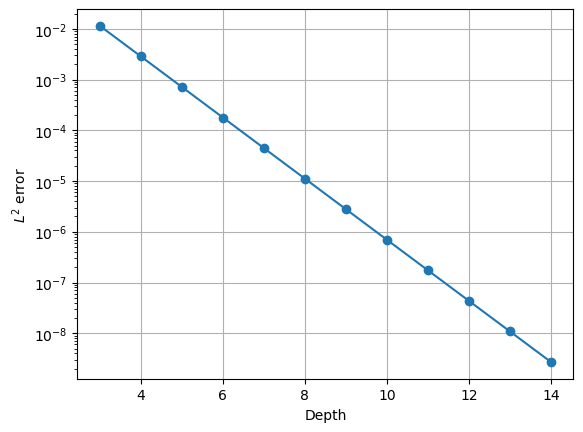

[0.011410880909246203,
 0.002852720227311558,
 0.0007131800568278893,
 0.00017829501420697295,
 4.4573753551742925e-05,
 1.1143438387935848e-05,
 2.785859596983983e-06,
 6.96464899246006e-07,
 1.7411622481153302e-07,
 4.352905620287267e-08,
 1.088226405081591e-08,
 2.720566012697404e-09]

In [13]:
def compute_err(depth):
    out_weights = [-4**(-k) for k in range(depth)]
    out_weights[0] = 1

    basenet = Phiwedge
    for j in range(depth-2):
        basenet = concatenate(basenet, Phiwedge)
        

    squarenet = YarotskyNet(basenet, out_weights)

    Npts = 10**6
    x = torch.linspace(0, 1, Npts)
    y = squarenet(x)
    x_np = x.cpu().detach().numpy()

    return np.linalg.norm(y.cpu().detach().numpy().flatten()-x_np**2)/np.sqrt(Npts)

err = []
all_depths = range(3, 15)
for depth in all_depths:
    err.append(compute_err(depth))

plt.semilogy(all_depths, err, 'o-')
plt.grid()
plt.xlabel("Depth")
plt.ylabel("$L^2$ error")
plt.show()

err